# Redes Multicapa de Aerolíneas

## Procesamiento de datos

Procesamiento de datos de rutas aéreas por distintas aerolíneas en R para obtener matrices de adyacencia asociados a diferentes multiplex.

In [4]:
getwd()

[1] "/Users/Yuriko/Documents/UNAM/Tesis_Lic/Code"

In [5]:
setwd("/Users/Yuriko/Documents/UNAM/Tesis_Lic/")

## Librerías

In [2]:
# Librerías necesarias
library(tidyverse)
library(data.table)
library(igraph)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spec

## Bases de datos

### Base de datos Rutas Aéreas (OpenFlights/Airline Route Mapper Route Database)

As of ***June 2014***, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe, as shown in the map above. Each entry contains the following information:

**Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.  
**Airline ID**	Unique OpenFlights identifier for airline (see Airline).  
**Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.  
**Source airport** ID	Unique OpenFlights identifier for source airport (see Airport)  
**Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.  
**Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)  
**Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.  
**Stops**	Number of stops on this flight ("0" for direct)  
**Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces  

The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

*Notes:*  
Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.  
Routes where one carrier operates both its own and codeshare flights are listed only once.

*Sample entries*  
BA,1355,SIN,3316,LHR,507,,0,744 777  
BA,1355,SIN,3316,MEL,3339,Y,0,744  
TOM,5013,ACE,1055,BFS,465,,0,320

##### La base de datos rutas_aereas.txt fue actualizada: # Date: 2014
Airline	Airline_ID	Source_Airport	Source_Airport_ID	Destination_Airport	Destination_Airport_ID	Codeshare	Stops_Number	Equipment
Líneas: 67663

In [6]:
# Se carga la tabla de rutas aéreas
tabla_rutas <- data.table::fread(
  input = "data/rutas_aereas.txt"
)

head(tabla_rutas)

Airline,Airline_ID,Source_Airport,Source_Airport_ID,Destination_Airport,Destination_Airport_ID,Codeshare,Stops_Number,Equipment
2B,410,AER,2965,KZN,2990,,0,CR2
2B,410,ASF,2966,KZN,2990,,0,CR2
2B,410,ASF,2966,MRV,2962,,0,CR2
2B,410,CEK,2968,KZN,2990,,0,CR2
2B,410,CEK,2968,OVB,4078,,0,CR2
2B,410,DME,4029,KZN,2990,,0,CR2


### Base de datos Rutas Aéreas (Airline Route Mapper)

Last updated: ***March 29, 2019***

##### La base de datos routes.txt fue actualizada: # Date: 2019-03-29 
Airline	From	To	Codeshare	Stops	Equipment
#C7	MAO	CIZ		0	EMB
Líneas:33544

In [26]:
# Se carga la tabla de routes
tabla_rutas2 <- data.table::fread(
  input = "data/routes.txt"
)

head(tabla_rutas2)

Airline,From,To,Codeshare,Stops,Equipment
0B,BCM,BGY,,0,735
0B,BCM,BLQ,,0,733 735 738
0B,BCM,BRU,,0,738
0B,BCM,DUB,,0,735 738
0B,BCM,FCO,,0,735 738
0B,BCM,LPL,,0,733 735 738


### Base de datos Aerolíneas (OpenFlights Airlines Database)

As of ***January 2012***, the OpenFlights Airlines Database contains 5888 airlines. Each entry contains the following information:

**Airline ID**	Unique OpenFlights identifier for this airline.  
**Name**	Name of the airline.  
**Alias**	Alias of the airline. For example, All Nippon Airways is commonly known as "ANA".  
**IATA**	2-letter IATA code, if available.  
**ICAO**	3-letter ICAO code, if available.  
**Callsign**	Airline callsign.  
**Country**	Country or territory where airline is incorporated.  
**Active**	"Y" if the airline is or has until recently been operational, "N" if it is defunct. This field is not reliable: in particular, major airlines that stopped flying long ago, but have not had their IATA code reassigned (eg. Ansett/AN), will incorrectly show as "Y".  

The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.  

*Notes:*   
Airlines with null codes/callsigns/countries generally represent user-added airlines. Since the data is intended primarily for current flights, defunct IATA codes are generally not included. For example, "Sabena" is not listed with a SN IATA code, since "SN" is presently used by its successor Brussels Airlines.  

*Sample entries*.  
324,"All Nippon Airways","ANA All Nippon Airways","NH","ANA","ALL NIPPON","Japan","Y"  
412,"Aerolineas Argentinas",\N,"AR","ARG","ARGENTINA","Argentina","Y"  
413,"Arrowhead Airways",\N,"","ARH","ARROWHEAD","United States","N"  

##### La base de datos aerolineas.txt fue actualizada: # Date:  Enero 2012
Líneas: 6160

In [8]:
# Se carga la tabla de aerolíneas
tabla_aerolineas <- data.table::fread(
  input = "data/aerolineas.txt"
  )

head(tabla_aerolineas)

Airline_ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
1,Private flight,\N,-,N/A,,,Y
2,135 Airways,\N,,GNL,GENERAL,United States,N
3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,2 Sqn No 1 Elementary Flying Training School,\N,,WYT,,United Kingdom,N
5,213 Flight Unit,\N,,TFU,,Russia,N
6,223 Flight Unit State Airline,\N,,CHD,CHKALOVSK-AVIA,Russia,N


### Base de datos Aerolíneas (Airline Route Mapper)

##### La base de datos airlines.txt fue actualizada: # Date: 2019-03-29 ?
Airline_ID	Airline_Name
Líneas: 689

In [9]:
# Se carga la tabla de airlines
tabla_aerolineas2 <- data.table::fread(
  input = "data/airlines.txt"
  )

head(tabla_aerolineas2)

Airline_ID,Airline_Name
0B,Blue Air
0V,Vasco - Vietnam Air Services Company
1X,Branson Air Express
2B,Albawings
2G,Angara Airlines
2I,Star Peru


### Base de datos Aeropuertos (OpenFlights Airports Database)

As of ***January 2017***, the OpenFlights Airports Database contains over 10,000 airports, train stations and ferry terminals spanning the globe, as shown in the map above. Each entry contains the following information:

**Airport ID**	Unique OpenFlights identifier for this airport.  
**Name**	Name of airport. May or may not contain the City name.  
**City**	Main city served by airport. May be spelled differently from Name.  
**Country**	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.  
**IATA**	3-letter IATA code. Null if not assigned/unknown.  
**ICAO**	4-letter ICAO code. Null if not assigned.  
**Latitude**	Decimal degrees, usually to six significant digits. Negative is South, positive is North.  
**Longitude**	Decimal degrees, usually to six significant digits. Negative is West, positive is East.  
**Altitude**	In feet.  
**Timezone**	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.  
**DST**	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time  
**Tz database time zone**	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".  
**Type**	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.  
**Source**	Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.  

The data is UTF-8 encoded.  

*Note:*   
Rules for daylight savings time change from year to year and from country to country. The current data is an approximation for 2009, built on a country level. Most airports in DST-less regions in countries that generally observe DST (eg. AL, HI in the USA, NT, QL in Australia, parts of Canada) are marked incorrectly.

*Sample entries*.  
507,"London Heathrow Airport","London","United Kingdom","LHR","EGLL",51.4706,-0.461941,83,0,"E","Europe/London","airport","OurAirports"  
26,"Kugaaruk Airport","Pelly Bay","Canada","YBB","CYBB",68.534401,-89.808098,56,-7,"A","America/Edmonton","airport","OurAirports"  
3127,"Pokhara Airport","Pokhara","Nepal","PKR","VNPK",28.200899124145508,83.98210144042969,2712,5.75,"N","Asia/Katmandu","airport","OurAirports"  
8810,"Hamburg Hbf","Hamburg","Germany","ZMB",\N,53.552776,10.006683,30,1,"E","Europe/Berlin","station","User"

##### La base de datos aeropuertos.txt fue actualizada: # Date:  
Líneas: 7543

In [10]:
# Se carga la tabla de aeropuertos
tabla_aeropuertos <- data.table::fread(
  input = "data/aeropuertos.txt"
  )

head(tabla_aeropuertos)

Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz_database_time_zone,Type,Source
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.392,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.726,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220,146,10,U,Pacific/Port_Moresby,airport,OurAirports
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669,19,10,U,Pacific/Port_Moresby,airport,OurAirports


##### La base de datos airports.txt fue actualizada: # Date: 2019-03-29 líneas:5819
Airport_ID	Latitude	Longitude	Airport_Name

In [11]:
# Se carga la tabla de airports
tabla_aeropuertos2 <- data.table::fread(
  input = "data/airports.txt"
  )

head(tabla_aeropuertos2)

Airport_ID,Latitude,Longitude,Airport_Name
AAA,-17.3542,-145.4961,Anaa
AAC,31.0733,33.8358,EL-ARISH
AAE,36.8222,7.8094,Annaba
AAF,29.7275,-85.0274,APALACHICOLA MUNI AIRPORT
AAG,-24.1036,-49.7900,ARAPOTI
AAL,57.0928,9.8492,Aalborg Airport


In [12]:
# Se carga la tabla de our airports
tabla_aeropuertos3 <- data.table::fread(
  input = "data/our_airports.txt"
  )

head(tabla_aeropuertos3)

ID,Ident,Type,Name,Latitude_deg,Longitude_deg,Elevation_ft,Continent,Iso_Country,Iso_Region,Municipality,Scheduled_service,Gps_code,IATA,Local_code,Home_link,Wikipedia_link,Keywords
6523,00A,heliport,Total Rf Heliport,40.07080,-74.93360,11,NA,US,US-PA,Bensalem,no,00A,,00A,,,
323361,00AA,small_airport,Aero B Ranch Airport,38.70402,-101.47391,3435,NA,US,US-KS,Leoti,no,00AA,,00AA,,,
6524,00AK,small_airport,Lowell Field,59.94920,-151.69600,450,NA,US,US-AK,Anchor Point,no,00AK,,00AK,,,
6525,00AL,small_airport,Epps Airpark,34.86480,-86.77030,820,NA,US,US-AL,Harvest,no,00AL,,00AL,,,
6526,00AR,closed,Newport Hospital & Clinic Heliport,35.60870,-91.25490,237,NA,US,US-AR,Newport,no,,,,,,00AR
322127,00AS,small_airport,Fulton Airport,34.94280,-97.81802,1100,NA,US,US-OK,Alex,no,00AS,,00AS,,,


##### La base de datos alliances.txt fue actualizada: # Date: 2019-03-29 líneas:15
Alliance_Name  List_of_Airlines

In [13]:
# Se carga la tabla de alianzas
tabla_alianzas <- data.table::fread(
  input = "data/alliances.txt"
  )

tabla_alianzas

Alliance_Name,List_of_Airlines
Star Alliance,9I A3 AC AI AV BR CA CM ET JP LH LO LR LX MS NH NZ O6 OA OS OU OZ P5 SA SG SK SN SQ TA TG TK TP UA WC WE ZH
oneworld,4M AA AY BA CJ CX EC EZ GH IB JC JJ JL KA LA LP MH MN N7 NU QF QR RJ S7 UL XL XM
SkyTeam,5D A5 AE AF AM AR AU AZ CI CT DL FM GA KE KL KQ ME MF MU OK RO SU SV UX VN WA WX
Alaska,AA AS AY BA CX DE EI EK FI FJ HU JL KE KS QF SQ
British Airways,4M AA AY AZ BA CJ CX EC EI EZ GH IB JC JJ JL KA LA LP MH MN N7 NU QF QR RJ S7 UL XL XM
Cathay Pacific,4M 9W AA AS AY BA CA CJ CX EC EI EZ GF GH IB JC JJ JL KA LA LH LP LX MH MN N7 NU NZ OS PH QF QR RJ S7 UL XL XM ZH
China Southern,3U AF AM AR AZ CZ DL FM KE GA KL KQ MU OK RO SU SV VN
Etihad,9W AA AT AZ EY G3 GA HU HM JU KE MH NH NZ OK OZ PG PR SK SN UL VA WY
Emirates,AS B6 CI EK FZ G3 JL JQ KE ME MF MH MK QF S7 SA SV TP
Lufthansa,9I A3 AC AI AV BR CA CX CM DE EW EN ET JP KC KM LG LH LO LR LX MS NH NZ O6 OA OS OU OZ P5 SA SG SK SN SQ TA TG TK TP UA WC WE ZH


## Procesamiento

In [14]:
names(tabla_aerolineas)

[1] "Airline_ID" "Name"       "Alias"      "IATA"       "ICAO"      
[6] "Callsign"   "Country"    "Active"

In [ ]:
# Renombramos las columnas de la tabla de aerolíneas
names(tabla_aerolineas) <- c("Airline ID", 
                             "Name", 
                             "Alias", 
                             "IATA", 
                             "ICAO", 
                             "Callsign", 
                             "Country", 
                             "Active"
                              )

In [15]:
# Checamos la tabla_aerolíneas con los nuevos nombres
tabla_aerolineas %>% head  

Airline_ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
1,Private flight,\N,-,N/A,,,Y
2,135 Airways,\N,,GNL,GENERAL,United States,N
3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,2 Sqn No 1 Elementary Flying Training School,\N,,WYT,,United Kingdom,N
5,213 Flight Unit,\N,,TFU,,Russia,N
6,223 Flight Unit State Airline,\N,,CHD,CHKALOVSK-AVIA,Russia,N


In [16]:
# Quitamos el primer renglón de la tabla_aerolíneas
tabla_aerolineas <- tabla_aerolineas [-c(1), ]

In [17]:
#Checamos la tabla_aerolíneas
tabla_aerolineas %>% head 

Airline_ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
2,135 Airways,\N,,GNL,GENERAL,United States,N
3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,2 Sqn No 1 Elementary Flying Training School,\N,,WYT,,United Kingdom,N
5,213 Flight Unit,\N,,TFU,,Russia,N
6,223 Flight Unit State Airline,\N,,CHD,CHKALOVSK-AVIA,Russia,N
7,224th Flight Unit,\N,,TTF,CARGO UNIT,Russia,N


In [18]:
head(tabla_rutas)

Airline,Airline_ID,Source_Airport,Source_Airport_ID,Destination_Airport,Destination_Airport_ID,Codeshare,Stops_Number,Equipment
2B,410,AER,2965,KZN,2990,,0,CR2
2B,410,ASF,2966,KZN,2990,,0,CR2
2B,410,ASF,2966,MRV,2962,,0,CR2
2B,410,CEK,2968,KZN,2990,,0,CR2
2B,410,CEK,2968,OVB,4078,,0,CR2
2B,410,DME,4029,KZN,2990,,0,CR2


In [19]:
#Quitamos columnas de ID que no necesitamos de tabla_rutas
tabla_rutas <- tabla_rutas %>%
  dplyr::select(Airline,
                Source_Airport,
                Destination_Airport,
                Codeshare,
                Stops_Number,
                Equipment)

In [20]:
#Checamos la tabla_rutas
tabla_rutas %>% head

Airline,Source_Airport,Destination_Airport,Codeshare,Stops_Number,Equipment
2B,AER,KZN,,0,CR2
2B,ASF,KZN,,0,CR2
2B,ASF,MRV,,0,CR2
2B,CEK,KZN,,0,CR2
2B,CEK,OVB,,0,CR2
2B,DME,KZN,,0,CR2


In [21]:
#Ahora hacemos un ciclo que recorra toda la tabla_aerolíneas, el cual 
#remueva los renglones correspondientes a las aerolíneas que NO están activas.

tabla_aerolineas <- tabla_aerolineas %>% 
  dplyr::filter(Active == "Y")

In [22]:
#Checamos la tabla_aerolineas
tabla_aerolineas %>% head

Airline_ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
10,40-Mile Air,\N,Q5,MLA,MILE-AIR,United States,Y
13,Ansett Australia,\N,AN,AAA,ANSETT,Australia,Y
14,Abacus International,\N,1B,,,Singapore,Y
21,Aigle Azur,\N,ZI,AAF,AIGLE AZUR,France,Y
22,Aloha Airlines,\N,AQ,AAH,ALOHA,United States,Y


In [ ]:
#Falta remover los renglones de la tabla_aeropuertos que contienen algún aeropuerto inactivo

In [ ]:
#Checamos la tabla_aeropuertos
tabla_aeropuertos %>% head

In [58]:
#Encontramos la intersección entre tabla_aerolineas y tabla_rutas
#para usar sólo las rutas de las aerolíneas activas.
tabla_rutas <- semi_join(tabla_rutas, tabla_aerolineas, by = c("Airline" = "IATA"))

In [ ]:
#Encontramos la intersección entre tabla_aeropuertos y tabla_rutas
#para usar sólo las rutas de las aeropuertos activos.

In [59]:
#Checamos la tabla_rutas modificada
tabla_rutas %>% head

Airline,Source_Airport,Destination_Airport,Codeshare,Stops_Number,Equipment
2B,AER,KZN,,0,CR2
2B,ASF,KZN,,0,CR2
2B,ASF,MRV,,0,CR2
2B,CEK,KZN,,0,CR2
2B,CEK,OVB,,0,CR2
2B,DME,KZN,,0,CR2


In [27]:
#Checamos la tabla_rutas2
tabla_rutas2 %>% head

Airline,From,To,Codeshare,Stops,Equipment
0B,BCM,BGY,,0,735
0B,BCM,BLQ,,0,733 735 738
0B,BCM,BRU,,0,738
0B,BCM,DUB,,0,735 738
0B,BCM,FCO,,0,735 738
0B,BCM,LPL,,0,733 735 738


In [24]:
#Quitamos el primer y segundo renglón de la tabla_aerolíneas
tabla_rutas2 <- tabla_rutas2 [-c(2), ]

In [28]:
#Checamos tabla_rutas2
tabla_rutas2 %>% head

Airline,From,To,Codeshare,Stops,Equipment
0B,BCM,BGY,,0,735
0B,BCM,BLQ,,0,733 735 738
0B,BCM,BRU,,0,738
0B,BCM,DUB,,0,735 738
0B,BCM,FCO,,0,735 738
0B,BCM,LPL,,0,733 735 738


In [ ]:
# Renombramos las columnas de la tabla_rutas2
names(tabla_rutas2) <- c("Airline", 
                         "Source", 
                         "Destination", 
                         "Codeshare", 
                         "Stops", 
                         "Equipment"
)

In [ ]:
#Checamos tabla_rutas2
tabla_rutas2 %>% head

In [29]:
#Encontramos la intersección entre tabla_aerolineas y tabla_rutas2
#para usar sólo las rutas de las aerolíneas activas.
tabla_rutas2 <- semi_join(tabla_rutas2, tabla_aerolineas, by = c("Airline" = "IATA"))

In [31]:
str(tabla_rutas) #2014

Classes ‘data.table’ and 'data.frame':	67663 obs. of  6 variables:
 $ Airline            : chr  "2B" "2B" "2B" "2B" ...
 $ Source_Airport     : chr  "AER" "ASF" "ASF" "CEK" ...
 $ Destination_Airport: chr  "KZN" "KZN" "MRV" "KZN" ...
 $ Codeshare          : chr  "" "" "" "" ...
 $ Stops_Number       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Equipment          : chr  "CR2" "CR2" "CR2" "CR2" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [32]:
str(tabla_rutas2) #2019

'data.frame':	32624 obs. of  6 variables:
 $ Airline  : chr  "0B" "0B" "0B" "0B" ...
 $ From     : chr  "BCM" "BCM" "BCM" "BCM" ...
 $ To       : chr  "BGY" "BLQ" "BRU" "DUB" ...
 $ Codeshare: chr  "" "" "" "" ...
 $ Stops    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Equipment: chr  "735" "733 735 738" "738" "735 738" ...
 - attr(*, ".internal.selfref")=<externalptr> 


Puesto que tabla_rutas2 contiene menos datos, usaremos esos...

In [33]:
#Queremos converir la columna de Codeshare a booleano
tabla_rutas2 <- tabla_rutas2 %>%
  dplyr::mutate(Codeshare = ifelse(test = Codeshare == "*",
                                   yes = TRUE,
                                   no = FALSE
  )
  )

In [34]:
#Checamos
tabla_rutas2 %>% head

Airline,From,To,Codeshare,Stops,Equipment
0B,BCM,BGY,FALSE,0,735
0B,BCM,BLQ,FALSE,0,733 735 738
0B,BCM,BRU,FALSE,0,738
0B,BCM,DUB,FALSE,0,735 738
0B,BCM,FCO,FALSE,0,735 738
0B,BCM,LPL,FALSE,0,733 735 738


In [35]:
#Ahora voy a quitar las rutas que contienen escalas, 
#i.e. los que son distintos de 0 en "Stops_Number"
tabla_rutas2 <- tabla_rutas2 %>% 
  dplyr::filter(Stops == 0)

In [36]:
#Checamos
tabla_rutas2 %>% head

Airline,From,To,Codeshare,Stops,Equipment
0B,BCM,BGY,FALSE,0,735
0B,BCM,BLQ,FALSE,0,733 735 738
0B,BCM,BRU,FALSE,0,738
0B,BCM,DUB,FALSE,0,735 738
0B,BCM,FCO,FALSE,0,735 738
0B,BCM,LPL,FALSE,0,733 735 738


In [37]:
#Ahora voy a quitar las rutas que contienen Codeshare, 
#i.e. los que son TRUE en "Codeshare"
tabla_rutas2 <- tabla_rutas2 %>%
  dplyr::filter(Codeshare == FALSE)

In [ ]:
#Checamos
tabla_rutas2

In [38]:
#Cambio orden de columnas
tabla_rutas2[ , -1]
tabla_rutas2[ , 1]

da.fr <- cbind(tabla_rutas2[,-1], 
               Airline = tabla_rutas2$Airline
)

From,To,Codeshare,Stops,Equipment
BCM,BGY,FALSE,0,735
BCM,BLQ,FALSE,0,733 735 738
BCM,BRU,FALSE,0,738
BCM,DUB,FALSE,0,735 738
BCM,FCO,FALSE,0,735 738
BCM,LPL,FALSE,0,733 735 738
BCM,LTN,FALSE,0,738
BCM,TRN,FALSE,0,733 735 738
CLJ,DUB,FALSE,0,738
CLJ,TLV,FALSE,0,738


[1] "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B"
   [15] "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B"
   [29] "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B"
   [43] "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B" "0B"
   [57] "0B" "0B" "0B" "0B" "0B" "2B" "2B" "2B" "2B" "2B" "2B" "2I" "2I" "2I"
   [71] "2I" "2J" "2J" "2J" "2J" "2J" "2J" "2J" "2J" "2J" "2J" "2J" "2M" "2M"
   [85] "2M" "2M" "2M" "2M" "2M" "2M" "2M" "2M" "2M" "2M" "2O" "2O" "2O" "2O"
   [99] "2O" "2O" "2O" "2O" "2O" "2O" "2O" "2O" "2O" "2O" "2O" "2O" "2T" "2T"
  [113] "2T" "2T" "2T" "2T" "2T" "2T" "2T" "2T" "2T" "2T" "2T" "2T" "2T" "3B"
  [127] "3B" "3B" "3B" "3B" "3B" "3B" "3B" "3B" "3E" "3E" "3E" "3E" "3E" "3E"
  [141] "3E" "3E" "3E" "3E" "3E" "3E" "3E" "3F" "3F" "3F" "3F" "3K" "3K" "3K"
  [155] "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K"
  [169] "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3K" "3M"
  [183] "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M"
  [197] "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3M" "3O" "3O" "3O"
  [211] "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O"
  [225] "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O"
  [239] "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O"
  [253] "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O" "3O"
  [267] "3O" "3O" "3O" "3O" "3O" "3O" "3P" "3P" "3P" "3P" "3P" "3P" "3P" "3R"
  [281] "3R" "3R" "3R" "3R" "3R" "3R" "3R" "3R" "3R" "3S" "3S" "3S" "3S" "3S"
  [295] "3S" "3S" "3S" "3S" "3S" "3S" "3T" "3T" "3T" "3T" "3T" "3T" "3T" "3T"
  [309] "3T" "3T" "3T" "3T" "3T" "3T" "3T" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [323] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [337] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [351] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [365] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [379] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [393] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [407] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [421] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [435] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [449] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [463] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [477] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [491] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [505] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [519] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [533] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [547] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [561] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [575] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [589] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [603] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [617] "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U" "3U"
  [631] "3U" "3U" "3U" "3U" "3U" "3W" "3W" "3W" "3W" "3W" "3W" "3W" "4B" "4B"
  [645] "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B"
  [659] "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4B" "4D" "4G"
  [673] "4G" "4G" "4G" "4N" "4N" "4N" "4N" "4N" "4N" "4N" "4N" "4N" "4N" "4N"
  [687] "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O"
  [701] "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O" "4O"
  [715] "4O" "4O" "4O" "4O

In [39]:
#Checo cómo se ve
da.fr %>% head

From,To,Codeshare,Stops,Equipment,Airline
BCM,BGY,FALSE,0,735,0B
BCM,BLQ,FALSE,0,733 735 738,0B
BCM,BRU,FALSE,0,738,0B
BCM,DUB,FALSE,0,735 738,0B
BCM,FCO,FALSE,0,735 738,0B
BCM,LPL,FALSE,0,733 735 738,0B


In [100]:
#Hago red
g <- igraph::graph_from_data_frame(d = da.fr, 
                                   directed = TRUE)
g

IGRAPH b271c52 DN-- 3045 29695 -- 
+ attr: name (v/c), Codeshare (e/l), Stops (e/n), Equipment (e/c),
| Airline (e/c)
+ edges from b271c52 (vertex names):
 [1] BCM->BGY BCM->BLQ BCM->BRU BCM->DUB BCM->FCO BCM->LPL BCM->LTN BCM->TRN
 [9] CLJ->DUB CLJ->TLV FCO->AHO IAS->BCN IAS->BRU IAS->BVA IAS->CGN IAS->FCO
[17] IAS->LTN IAS->MUC LCA->ATH LCA->BHX LCA->LTN LCA->SKG OTP->AGP OTP->ARN
[25] OTP->BCM OTP->BCN OTP->BHX OTP->BRU OTP->CDG OTP->CGN OTP->CLJ OTP->CPH
[33] OTP->CTA OTP->DUB OTP->FCO OTP->FLR OTP->GLA OTP->HAM OTP->HEL OTP->IAS
[41] OTP->LCA OTP->LIN OTP->LIS OTP->LPL OTP->LTN OTP->LYS OTP->MAD OTP->NAP
[49] OTP->NCE OTP->OMR OTP->OSL OTP->STR OTP->TLV OTP->VLC SBZ->STR TRN->AHO
+ ... omitted several edges

In [101]:
is.simple(g)

[1] FALSE

Se grafican las rutas aéreas de todas las aerolíneas como una red monocapa.

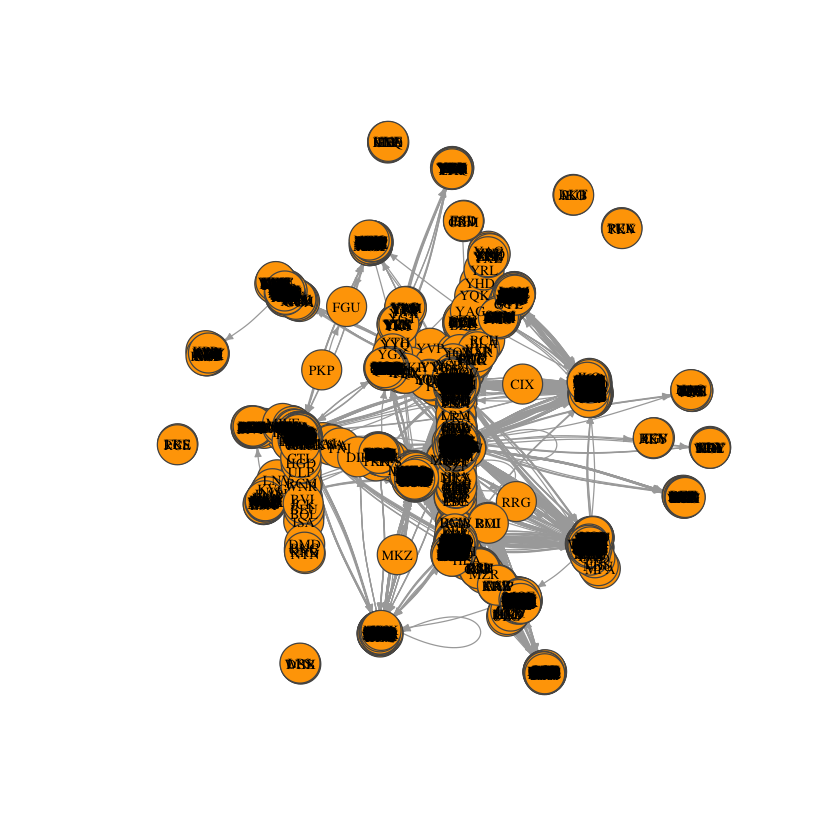

In [41]:
#Graficamos todo en una capa
plot(g, edge.arrow.size=.4, edge.curved=.1,
     vertex.color="orange", 
     vertex.frame.color="#555555",
     vertex.label.color="black",
     vertex.label.cex=.7)

Sacamos la matriz de adyacencia.

In [42]:
matriz_multi <- as_adjacency_matrix(g)

In [43]:
matriz_multi

   [[ suppressing 32 column names ‘BCM’, ‘CLJ’, ‘FCO’ ... ]]


3045 x 3045 sparse Matrix of class "dgCMatrix"
                                                                          
BCM . . 1 . . . . 1 . . . . . . . . . . . . . . . . . . . . . . . . ......
CLJ . . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . ......
FCO . . . . . . . 1 2 . . . . . . . . . . . . . . . . . . . . . . . ......
IAS . 1 1 . 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
LCA . . 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
OTP 1 2 2 2 1 . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . ......
SBZ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
TRN . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
TIA . . . . . . . 1 . . . . . . . . . . . . . . . . . . . . . . . . ......
LIM . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ACC . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
BOY . . . . . . . . . . . . . . . . . . . . . . . . .

In [44]:
# Checamos la estructura de la matriz_multi
str(matriz_multi)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:22610] 5 3 5 253 528 544 587 591 626 723 ...
  ..@ p       : int [1:3046] 0 1 17 133 140 187 234 244 265 278 ...
  ..@ Dim     : int [1:2] 3045 3045
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:3045] "BCM" "CLJ" "FCO" "IAS" ...
  .. ..$ : chr [1:3045] "BCM" "CLJ" "FCO" "IAS" ...
  ..@ x       : num [1:22610] 1 1 2 1 1 1 1 1 1 1 ...
  ..@ factors : list()


Pruebas para ver por qué la matriz de adyacencia de la matriz_multi tiene pesos.

In [45]:
pruebaOTP <- tabla_rutas2 %>%
  dplyr::filter(From == "OTP")

In [46]:
pruebaOTP %>% head

Airline,From,To,Codeshare,Stops,Equipment
0B,OTP,AGP,FALSE,0,738
0B,OTP,ARN,FALSE,0,733 735
0B,OTP,BCM,FALSE,0,738
0B,OTP,BCN,FALSE,0,733 734 738
0B,OTP,BHX,FALSE,0,73G 738
0B,OTP,BRU,FALSE,0,733 734 735 73G 738


In [47]:
str(pruebaOTP)

'data.frame':	96 obs. of  6 variables:
 $ Airline  : chr  "0B" "0B" "0B" "0B" ...
 $ From     : chr  "OTP" "OTP" "OTP" "OTP" ...
 $ To       : chr  "AGP" "ARN" "BCM" "BCN" ...
 $ Codeshare: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Stops    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Equipment: chr  "738" "733 735" "738" "733 734 738" ...


In [48]:
pruebaOTP20 <- pruebaOTP %>%
  dplyr::filter(To == "BCM")

In [49]:
pruebaOTP20

Airline,From,To,Codeshare,Stops,Equipment
0B,OTP,BCM,FALSE,0,738


In [50]:
pruebaOTP21 <- pruebaOTP %>%
  dplyr::filter(To == "CLJ")

In [51]:
pruebaOTP21

Airline,From,To,Codeshare,Stops,Equipment
0B,OTP,CLJ,FALSE,0,738
RO,OTP,CLJ,FALSE,0,AT5 733 73W 738


De estas pruebas concluimos que los pesos de la matriz_multi corresponden a rutas entre los mismos aeropuertos pero de diferentes aerolíneas.

Así que, la matriz de adyacencia que usaremos es una en la que convirtamos los pesos a 1's.

In [52]:
#Primero la convertimos a matrix
matriz_multi <- as.matrix(matriz_multi)

In [53]:
str(matriz_multi)

 num [1:3045, 1:3045] 0 0 0 0 0 1 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:3045] "BCM" "CLJ" "FCO" "IAS" ...
  ..$ : chr [1:3045] "BCM" "CLJ" "FCO" "IAS" ...


In [104]:
matriz_multi

,BCM,CLJ,FCO,IAS,LCA,OTP,SBZ,TRN,TIA,LIM,⋯,MYA,KRB,CVQ,EPR,MJK,HGD,ARM,OAG,CTL,LRE
BCM,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CLJ,0,0,0,0,1,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FCO,0,0,0,0,0,0,0,1,2,0,⋯,0,0,0,0,0,0,0,0,0,0
IAS,0,1,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LCA,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
OTP,1,2,2,2,1,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
SBZ,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TRN,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TIA,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LIM,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [102]:
# Convertimos matriz_multi a una matriz de adyacencia dirigida y no pesada.
matriz_multi_uw <- ifelse(matriz_multi == 0,
                            yes = 0,
                             no = 1) 

In [103]:
matriz_multi_uw

,BCM,CLJ,FCO,IAS,LCA,OTP,SBZ,TRN,TIA,LIM,⋯,MYA,KRB,CVQ,EPR,MJK,HGD,ARM,OAG,CTL,LRE
BCM,0,0,1,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CLJ,0,0,0,0,1,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FCO,0,0,0,0,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
IAS,0,1,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LCA,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
OTP,1,1,1,1,1,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
SBZ,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TRN,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TIA,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LIM,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Ahora guardo esta matriz "matriz_multi_uw" 

In [107]:
write.csv(matriz_multi_uw, "data/matriz_multi_uw.csv")

In [106]:
write.matrix

Medidas de centralidad de esta red monocapa de rutas.

In [ ]:
#Grado
degree(g) %>% head

In [ ]:
#Distribución de grado


In [ ]:
#Estructura de degree(g)
str(degree(g))

In [ ]:
#Average Shortest Path Length
average.path.length(g)

In [ ]:
#Betweenness
betweenness(g) %>% head

In [ ]:
#Diámetro
diameter(g)

In [ ]:
#Radio
radius(g)

In [ ]:
#Excentricidad
eccentricity(g) %>% head

In [ ]:
#Transitivity/Clustering Coefficient
transitivity(g)

Para crear la red multicapa

In [77]:
#Vemos cuántas aerolíneas distintas tenemos
length(unique(da.fr$Airline))

[1] 548

In [78]:
#Tomo todas las aerolíneas posibles con unique
#Como las aerolíneas son de tipo Factor, lo convierto a caracteres 
mis_aerolineas <- as.character(unique(da.fr$Airline)) 

In [79]:
#La lista "hereda" los nombres
names(mis_aerolineas) <- mis_aerolineas

In [80]:
#Se aplica el filtrado para aerolíneas, que corresponderán a distintas capas 
#y le agrega la gráfica a cada capa
graph_capas <- lapply(mis_aerolineas, FUN = function(i){
  xf <- dplyr::filter(.data = da.fr, Airline == i)
  g <- igraph::graph_from_data_frame(d = xf, 
                                     directed = TRUE)
}) 

In [ ]:
#Eg. Se grafica la red de la capa correspondiente a la aerolínea 2B
plot(graph_capas$`2B`)

In [ ]:
#Eg. Se grafica la red de la capa correspondiente a la aerolínea AM
plot(graph_capas$AM)

In [ ]:
#Eg. Se grafica la red de la capa correspondiente a la aerolínea OTP??????
plot(graph_capas$AM)

In [ ]:
#Agrego al ciclo las centralidades de cada capa
capas <- lapply(mis_aerolineas, FUN = function(i){
  xf <- dplyr::filter(.data = da.fr, Airline == i)
  g <- igraph::graph_from_data_frame(d = xf, 
                                     directed = TRUE)
  Resultados <- list(APL = average.path.length(g), 
                     Diametro = diameter(g),
                     Radio = radius(g),
                     Clustering_Coefficient = transitivity(g),
                     Red = g)
  
  return(Resultados)
}) 

In [ ]:
#Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea 2B
capas$`2B`$APL

In [ ]:
#Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea AM
capas$AM$APL

In [ ]:
#Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea AM
capas$AM$Diametro

In [ ]:
#Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea AM
capas$AM$Radio

In [ ]:
#Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea AM
capas$AM$Clustering_Coefficient

In [ ]:
#Eg. Para graficar la capa correspondiente a la aerolínea 2I.
#Graficamos la entrada Red de la aerolínea 2I
plot(capas$`2I`$Red)

In [ ]:
#Juntamos toda la información de las capas
capas_totales <- capas[1:567
                 ]

In [ ]:
#Checamos los nombres de todas las aerolíneas
names(capas_totales)

In [ ]:
#Generalizamos.
#Hacemos un ciclo que llame a la función capas y las grafique
for(i in seq_along(capas)){
  plot(capas[[i]][["Red"]],
       main = names(capas[i]))
}

In [ ]:
#Eg. Llamamos la entrada 1 del conjunto de capas totales y después llamamos la Red
capas[[1]][["Red"]]

In [ ]:
#Para graficarlo
plot(capas_totales[[1]][["Red"]])

In [ ]:
#Para averiguar cuántos nodos tenemos en la tabla_rutas2